# Add human-in-the-loop controls
## 1. Add the human_assistance tool

In [1]:

import os

os.environ["TAVILY_API_KEY"] = "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"

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
        # model="Qwen/Qwen2.5-72B-Instruct",
        model="Qwen/Qwen3-8B",
        # 硅基流动
        api_key="sk-jvjyawqpodlkxlywatvemcdykkrbvthhjyjyapyvtnifwlbl",
        base_url="https://api.siliconflow.cn/v1/",
        # # modelscope 
        # base_url="https://api-inference.modelscope.cn/v1/",
        # api_key="ms-e2666046-2f3b-4c76-bcc0-e21f8ebf9ea1",
    )

In [2]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

## 2. Compile the graph

In [3]:
memory = InMemorySaver()

graph = graph_builder.compile(checkpointer=memory)

## 3. Visualize the graph (optional)

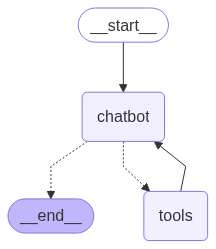

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 4. Prompt the chatbot

In [5]:
user_input = "我需要一些专家指导，用于构建一个 AI 智能体。你能为我提供帮助吗？"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

我需要一些专家指导，用于构建一个 AI 智能体。你能为我提供帮助吗？
================================== Ai Message ==================================
Tool Calls:
  tavily_search (0198e5707c9ebd436b41b49771ccce35)
 Call ID: 0198e5707c9ebd436b41b49771ccce35
  Args:
    query: 构建AI智能体的专家指导
    topic: general
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "构建AI智能体的专家指导", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://baoyu.io/translations/a-practical-guide-to-building-agents", "title": "OpenAI: 构建AI 智能体实用指南 - 宝玉的分享", "content": "_控制工作流的执行_ 2。这使其能够超越简单的、单轮次的问答交互。那些集成 LLM 但未用其控制工作流执行的应用，例如纯粹的聊天机器人、单步翻译工具或情感分类器，并不属于智能体的范畴 1。 尽管 AI 智能体功能强大，但并非所有自动化任务都需要或适合采用智能体架构。在投入资源构建之前，至关重要的是对应用场景进行审慎评估，以确认该场景确实需要智能体级别的推理能力。在许多情况下，一个设计良好的传统确定性解决方案可能更为高效和稳健 3。智能体特别适用于那些传统基于规则的自动化方法难以应对或效果不佳的工作流 2。 构建一个功能强大且稳定可靠的智能体，需要建立在三个紧密协作的核心

In [6]:
snapshot = graph.get_state(config)
snapshot.next

()

## 5. Resume execution

In [ ]:
human_response = (
    "我们的专家在这里帮助您！我们建议您检查一下 LangGraph 来构建您的智能体。",
    "LangGraph 是一个更可靠、更可扩展的智能体构建工具，而简单的自主智能体则不是。",
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================



根据搜索结果，以下是构建AI智能体的关键指导框架：

1. **核心架构**  
   - 建议从单一智能体系统开始（如OpenAI的"运行循环"设计），包含：  
     * LLM模型（如gpt-4o/gpt-4o-mini）作为"大脑"  
     * 工具集（Tools）作为"神经系统"和"四肢"，用于与外部系统交互  
     * 指令集（Instructions）作为行为准则  
   - 当任务复杂度超出单个智能体处理能力时，再考虑多智能体协作系统

2. **工具集成**  
   - 必须组件：  
     * 网络搜索工具（web_search_preview）获取实时数据  
     * 文件搜索工具（file_search）结合向量数据库  
     * 计算机使用工具（如代码执行）  
   - 工具调用示例：  
     ```javascript
     const response = await openai.responses.create({
       model: "gpt-4o",
       tools: [{ type: "web_search_preview" }],
       input: "What was a positive news story that happened today?"
     });
     ```

3. **安全设计**  
   - 需建立分层防御体系：  
     * 输入过滤：LLM相关性分类器 + 规则过滤器  
     * 工具风险评估：高风险操作需额外授权  
     * 输出验证：确保符合品牌语调和合规要求  
   - 必须包含人工监督机制（Human-in-the-Loop, HITL）以应对不可预见的风险

4. **实践建议**  
   - 推荐参考OpenAI的完整指南（https://baoyu.io/translations/a-practical-guide-to-building-agents）  
   - 开发前需评估场景是否需要智能体架构：  


# 完整代码

In [1]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langchain_openai import ChatOpenAI
import os

os.environ["TAVILY_API_KEY"] = "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"

llm = ChatOpenAI(
        # model="Qwen/Qwen2.5-72B-Instruct",
        model="Qwen/Qwen3-8B",
        # 硅基流动
        api_key="sk-jvjyawqpodlkxlywatvemcdykkrbvthhjyjyapyvtnifwlbl",
        base_url="https://api.siliconflow.cn/v1/",
        # modelscope
        # base_url="https://api-inference.modelscope.cn/v1/",
        # api_key="ms-e2666046-2f3b-4c76-bcc0-e21f8ebf9ea1",
    )

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [2]:
user_input = "如何使用LangGraph来构建一个 AI 智能体？请给出具体的步骤？"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

如何使用LangGraph来构建一个 AI 智能体？请给出具体的步骤？
================================== Ai Message ==================================
Tool Calls:
  tavily_search (0198e57e448b534f7a0ea8fb31409554)
 Call ID: 0198e57e448b534f7a0ea8fb31409554
  Args:
    query: 如何使用LangGraph构建AI智能体 步骤
    include_domains: ['langchain.github.io', 'docs.langchain.com']
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "如何使用LangGraph构建AI智能体 步骤", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Langchain Overview - Docs by LangChain", "url": "https://docs.langchain.com/langgraph-platform/langgraph-studio", "content": "LangGraph Studio LangGraph Platform ##### LangGraph Studio *   Manage assistants LangGraph Studio *   LangGraph Platform *   LangGraph Server LangGraph Studio is a specialized agent IDE that e

In [3]:
human_response = (
    "我们的专家在这里帮助您！我们建议您使用 LangGraph 来构建您的智能体。",
    "LangGraph 是一个更可靠、更可扩展的智能体构建工具，而简单的自主智能体则不是。",
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================



以下是使用 LangGraph 构建 AI 智能体的详细步骤，基于 LangChain 官方文档和 LangGraph 平台的功能：

---

### **1. 安装依赖**
- 使用 Python SDK 安装 LangGraph：
  ```bash
  pip install langgraph-sdk
  ```
- 若需本地开发，安装同步/异步客户端（根据需求选择）：
  ```python
  from langgraph_sdk import get_sync_client  # 同步客户端
  # 或
  from langgraph_sdk import get_client       # 异步客户端
  ```

---

### **2. 初始化 AI 智能体**
- **定义智能体的核心逻辑**：  
  使用 LangGraph 提供的工具（如 `Agent` 类）创建智能体，指定其行为规则和工具集。例如：
  ```python
  from langgraph_sdk import Agent
  agent = Agent(
      name="my_agent", 
      tools=[tool1, tool2],  # 注册可用工具
      prompt_template="你是一个助手，可以完成以下任务：{task}。请使用工具 {tool} 来处理。"  # 定义交互模板
  )
  ```

- **配置运行环境**：  
  - **本地运行**：通过 `get_sync_client` 或 `get_client` 启动本地服务，直接测试智能体逻辑。
  - **部署到 LangGraph 平台**：将智能体代码上传至平台，利用其托管服务和可视化工具。

---

### **3. 构建工作流（Graph）**
- **设计节点和流程**：  
  定义智能体的执行路径，例如：
  ```python
  graph = Graph(
      nodes=[
          Node("start", input="用户请求", 